<a href="https://colab.research.google.com/github/dbos23/Predicting-the-IMDB-Scores-of-the-Netflix-Library/blob/main/Thinkful_Supervised_Learning_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

I'll be working with a dataset stored in a file called titles.csv that I found on Kaggle at this link:
https://www.kaggle.com/datasets/dgoenrique/netflix-movies-and-tv-shows?resource=download

I'll be creating a regression model to try to predict the IMDB rating of TV shows on Netflix given other features of the shows.

# Dataframe creation and data cleaning

First I'll create the dataframe and then I'll remove the movies because I'm only interested in TV shows and this dataset contains both.

In [ ]:
raw_df = pd.read_csv('/content/titles.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6137 non-null   object 
 1   title                 6137 non-null   object 
 2   type                  6137 non-null   object 
 3   description           6114 non-null   object 
 4   release_year          6137 non-null   int64  
 5   age_certification     3394 non-null   object 
 6   runtime               6137 non-null   int64  
 7   genres                6137 non-null   object 
 8   production_countries  6137 non-null   object 
 9   seasons               2306 non-null   float64
 10  imdb_id               5741 non-null   object 
 11  imdb_score            5669 non-null   float64
 12  imdb_votes            5653 non-null   float64
 13  tmdb_popularity       6061 non-null   float64
 14  tmdb_score            5885 non-null   float64
dtypes: float64(5), int64(

In [ ]:
raw_df['type'].unique()

array(['SHOW', 'MOVIE'], dtype=object)

In [ ]:
raw_df = raw_df[raw_df['type'] == 'SHOW']
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2306 entries, 0 to 6122
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2306 non-null   object 
 1   title                 2306 non-null   object 
 2   type                  2306 non-null   object 
 3   description           2291 non-null   object 
 4   release_year          2306 non-null   int64  
 5   age_certification     2046 non-null   object 
 6   runtime               2306 non-null   int64  
 7   genres                2306 non-null   object 
 8   production_countries  2306 non-null   object 
 9   seasons               2306 non-null   float64
 10  imdb_id               2168 non-null   object 
 11  imdb_score            2143 non-null   float64
 12  imdb_votes            2143 non-null   float64
 13  tmdb_popularity       2278 non-null   float64
 14  tmdb_score            2212 non-null   float64
dtypes: float64(5), int64(

The target variable is imdb_score so I can safely remove any entries with a missing value for that. I can also remove tmdb_popularity and tmdb_score because those are ratings from a different website. If I had such a useful evaluation of the opinion of the audience, I wouldn't need to predict the score from IMDB.

In [ ]:
raw_df = raw_df.dropna(subset='imdb_score')
raw_df = raw_df.drop(['tmdb_popularity', 'tmdb_score'], axis=1)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143 entries, 7 to 6122
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2143 non-null   object 
 1   title                 2143 non-null   object 
 2   type                  2143 non-null   object 
 3   description           2142 non-null   object 
 4   release_year          2143 non-null   int64  
 5   age_certification     1929 non-null   object 
 6   runtime               2143 non-null   int64  
 7   genres                2143 non-null   object 
 8   production_countries  2143 non-null   object 
 9   seasons               2143 non-null   float64
 10  imdb_id               2143 non-null   object 
 11  imdb_score            2143 non-null   float64
 12  imdb_votes            2143 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 234.4+ KB


The only columns that still have missing values are age_certification and description. Description has only one missing value and it's unlikely to be a useful predictor so this is not an issue that needs to be addressed. I'll take a closer look at age_certification.

In [ ]:
for rating in raw_df['age_certification'].unique().tolist():
  print(f'Count for {rating}: {raw_df["age_certification"].tolist().count(rating)}')

Count for TV-14: 459
Count for TV-MA: 972
Count for TV-PG: 192
Count for TV-Y: 98
Count for nan: 214
Count for TV-Y7: 119
Count for TV-G: 82
Count for TV-Y7-FV: 7


In [ ]:
for rating in raw_df['age_certification'].unique().tolist():
  print(f'Average imdb score for {rating}: {raw_df[raw_df["age_certification"]==rating]["imdb_score"].mean()}')

Average imdb score for TV-14: 7.184749455337691
Average imdb score for TV-MA: 6.993827160493828
Average imdb score for TV-PG: 7.020833333333333
Average imdb score for TV-Y: 6.681632653061225
Average imdb score for nan: nan
Average imdb score for TV-Y7: 6.8655462184873945
Average imdb score for TV-G: 6.523170731707316
Average imdb score for TV-Y7-FV: 7.114285714285714


I'm reluctant to discard all the datapoints with a missing value for age_certification. Instead I'll create a 'missing' category for all of the null values so as not to lose the other information provided by those datapoints.

In [ ]:
raw_df['age_certification'].fillna('missing', inplace=True)

In order to make sure there are no missing values with a value other than nan, I'll take a look at the unique values for each variable, skipping the variables used solely for identification (such as id, title, and description).

In [ ]:
variables = ['release_year', 'age_certification', 'runtime', 'genres',
             'production_countries', 'seasons', 'imdb_score', 'imdb_votes']

for var in variables:
  print(f'Unique values of {var}: {raw_df[var].unique()}')
  print('-'*50)
  print('-'*50)
  print('-'*50)

Unique values of release_year: [1969 1972 1989 1984 1987 1981 2000 1999 1997 1998 1995 1992 1993 1994
 1996 2008 2010 2005 2003 2009 2002 2006 2001 2007 2004 2011 2012 2014
 2013 2015 2016 2018 2017 2019 2020 2022 2021 2023]
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Unique values of age_certification: ['TV-14' 'TV-MA' 'TV-PG' 'TV-Y' 'missing' 'TV-Y7' 'TV-G' 'TV-Y7-FV']
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Unique values of runtime: [ 30  43  24  10  14  48  23  22  46  25  32  26  21  45  20  40  19  29
  28  58  44  47  27  49  64  59  18   9  37   6  15  11  61  72  67  56
   7   0  55  54  57  42  53  17  16   3   2  60  65  52  76   4  63  73
  50  51  41  62  31  35  71  84   8  92   5  12  70 101  36  13  69  87
  33  39  34  38  66  75  91  68  89  80  86  

It looks like there are some rows with a runtime of zero, which doesn't make any sense so they must be missing values.

In [ ]:
raw_df[raw_df['runtime']==0]

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
455,ts74931,Kung Fu Panda Awesome Secrets,SHOW,"In this pair of adventures, Po tells the story...",2008,TV-PG,0,"['action', 'family', 'animation', 'comedy']",['US'],1.0,tt6963796,7.0,101.0
515,ts204466,Pecados capitales,SHOW,Evaristo Salinas is a successful businessman i...,2002,TV-MA,0,"['romance', 'comedy', 'drama']",['CO'],1.0,tt0355119,8.5,201.0
2583,ts250172,Afronta!,SHOW,Afronta invites contemporary black artists and...,2017,TV-PG,0,['documentation'],['BR'],1.0,tt12467250,7.7,10.0
4182,ts251607,Word Party Songs,SHOW,"Sing along and dance with Bailey, Franny, Kip,...",2020,TV-Y,0,"['animation', 'family']",['US'],1.0,tt12748268,4.0,19.0
4219,ts268592,Beyblade Burst Rise,SHOW,"Beyblade Burst Rise, also known as Beyblade Bu...",2019,TV-Y7-FV,0,"['action', 'scifi', 'thriller', 'animation', '...","['JP', 'ES']",1.0,tt11916718,6.0,193.0
4333,ts356131,Dragon Age: Absolution,SHOW,"With great power at stake, a group of rebel ma...",2022,TV-MA,0,"['animation', 'action', 'scifi', 'fantasy']",['US'],1.0,tt21031054,6.4,2856.0
4598,ts329700,Life After Death with Tyler Henry,SHOW,Clairvoyant medium Tyler Henry offers clarity ...,2022,TV-MA,0,['reality'],['US'],1.0,tt18217272,6.1,1114.0
4739,ts346007,Savage Beauty,SHOW,"In Savage Beauty, Rosemary Zimu plays Zinhle -...",2022,TV-MA,0,['drama'],['US'],1.0,tt19671142,5.6,460.0
4752,ts352579,As the Crow Flies,SHOW,A young fan maneuvers her way into a seasoned ...,2022,TV-MA,0,"['drama', 'comedy']",['TR'],1.0,tt13323566,6.3,4613.0
4770,ts269286,Once Upon a Time... Happily Never After,SHOW,A tragically separated couple must find each o...,2022,TV-MA,0,"['scifi', 'comedy', 'fantasy']",['ES'],1.0,tt13560186,5.4,584.0


Fortunately, there are only 17 such rows, few enough that I can check the runtimes online and manually enter that information into the dataframe.

In [ ]:
raw_df.loc[455, 'runtime'] = 30 #Kung Fu Panda Awesome Secrets
raw_df.loc[515, 'runtime'] = 45 #Pecados capitales
raw_df.loc[2583, 'runtime'] = 14 # Afronta!
raw_df.loc[4182, 'runtime'] = 4 #Word Party Songs
raw_df.loc[4219, 'runtime'] = 11 #Beyblade Burst Rise
raw_df.loc[4333, 'runtime'] = 30 #Dragon Age: Absolution
raw_df.loc[4598, 'runtime'] = 43 #Life After Death With Tyler Henry
raw_df.loc[4739, 'runtime'] = 51 #Savage Beauty
raw_df.loc[4752, 'runtime'] = 46 #As the Crow Flies
raw_df.loc[4770, 'runtime'] = 30 #Once Upon a Time ... Happily Never After
raw_df.loc[4812, 'runtime'] = 45 #Dated and Related
raw_df.loc[5103, 'runtime'] = 56 #Terim
raw_df.loc[5671, 'runtime'] = 23 #Sharkdog
raw_df.loc[5788, 'runtime'] = 32 #The Most Beautiful Flower
raw_df.loc[6051, 'runtime'] = 26 #Make My Day
raw_df.loc[6081, 'runtime'] = 100 #Bill Russell: Legend
raw_df.loc[6089, 'runtime'] = 47 #Pressure Cooker

My next task will be to examine the many values of genres. Each one is supposed to be a list but is currently stored as a string so I'll have to do some feature engineering to clean that up. I'll have to do the same with production_countries.

In [ ]:
raw_df['genres'] = raw_df['genres'].str.strip("[]").str.replace("'", "").str.split(", ")
raw_df['production_countries'] = raw_df['production_countries'].str.strip("[]").str.replace("'", "").str.split(", ")

In [ ]:
genres_list = []

for entry in raw_df['genres']:
  for item in entry:
    if item not in genres_list:
      genres_list.append(item)

countries_list = []

for entry in raw_df['production_countries']:
  for item in entry:
    if item not in countries_list:
      countries_list.append(item)

print(f'Genres: {genres_list}')
print('-'*380)
print(f'Countries: {countries_list}')

Genres: ['comedy', 'european', 'animation', 'family', 'fantasy', 'music', 'drama', 'action', 'war', 'crime', 'scifi', 'reality', 'western', 'thriller', 'documentation', 'romance', 'horror', 'sport', 'history', '']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Countries: ['GB', 'US', 'JP', 'CA', 'FR', 'AU', 'AR', 'DK', 'CO', 'IT', 'TW', 'KR', 'CN', 'ES', 'RU', 'IN', 'SG', '', 'NO', 'CL', 'SA', 'ZA', 'IS', 'IL', 'PL', 'TR', 'FI', 'NG', 'NL', 'IE', 'UA', 'BE', 'DE', 'BR', 'MX', 'AT', 'BY', 'NZ', 'TH', 'ID', 'AE', 'SE', 'PR', 'PH', 'PE', 'LU', 'KW', 'SN', 'HK', 'JO', 'LB', 'CZ', 'EG', 'MY', 'KN', 'MA', 'TN', 'PT', 'KE', 'CH', 'VN', 'IO']


There are empty string values for production countries and genres, which appear to be missing values. I could replace them with another value as I replaced the missing values for age certification with 'missing' but I'll be replacing these with dummy variables before the modeling stage so each entry with a missing value will just have values of 0 for each dummy. I'll remove the empty strings from the lists now.

In [ ]:
genres_list.remove('')
countries_list.remove('')

Now I'll move on to dealing with the outliers. The numeric variables to consider are release_year, runtime, seasons, imdb_score, and imdb_votes.

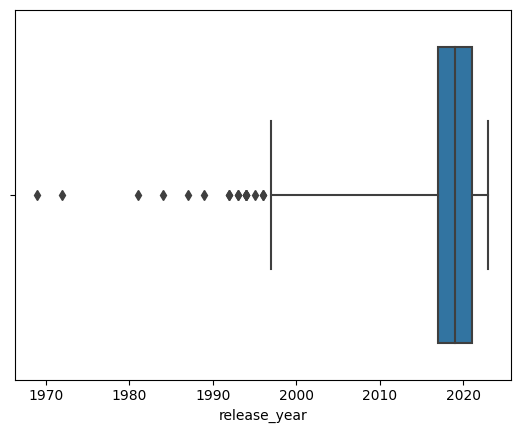

In [ ]:
sns.boxplot(data=raw_df, x='release_year', whis=5)
plt.show()

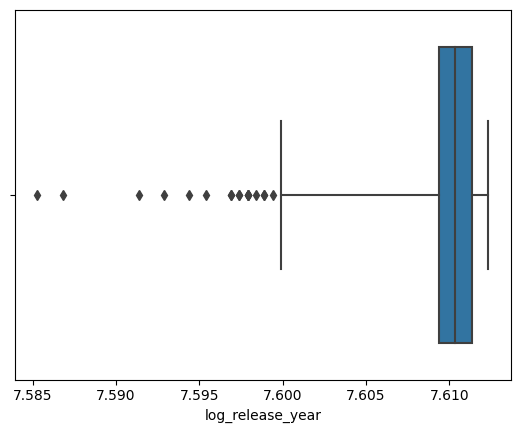

In [ ]:
raw_df['log_release_year'] = np.log(raw_df['release_year'])
sns.boxplot(data=raw_df, x='log_release_year', whis=5)
plt.show()

Taking the log did nothing to get rid of the outliers for release year. I'll try winsorizing instead.

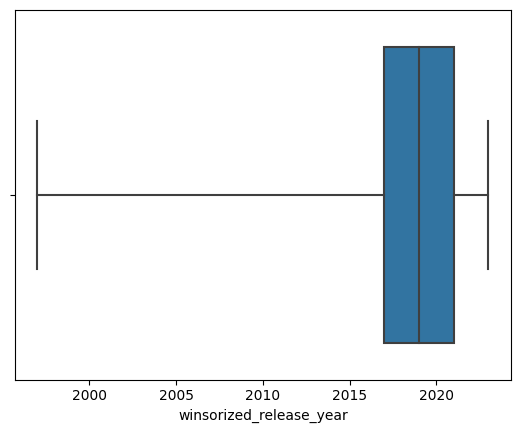

In [ ]:
raw_df['winsorized_release_year'] = stats.mstats.winsorize(raw_df['release_year'], (.008, 0))
sns.boxplot(data=raw_df, x='winsorized_release_year', whis=5)
plt.show()

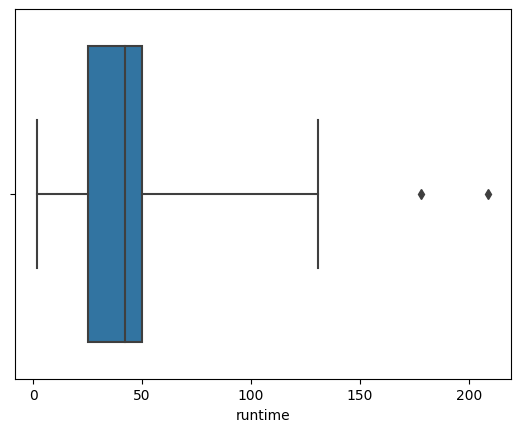

In [ ]:
sns.boxplot(data=raw_df, x='runtime', whis=5)
plt.show()

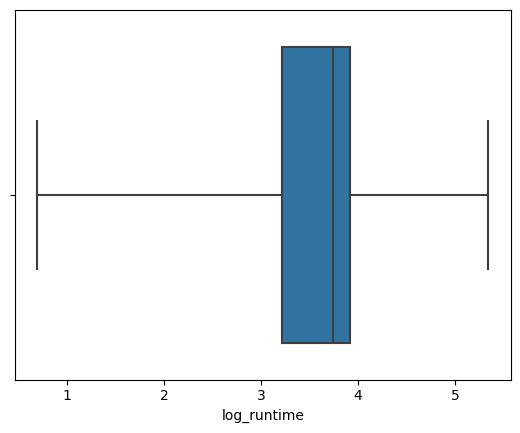

In [ ]:
raw_df['log_runtime'] = np.log(raw_df['runtime'])
sns.boxplot(data=raw_df, x='log_runtime', whis=5)
plt.show()

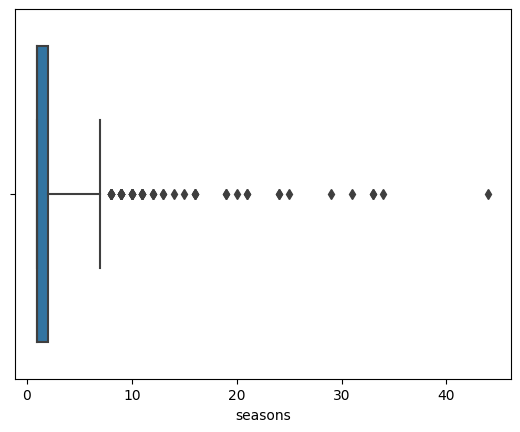

In [ ]:
sns.boxplot(data=raw_df, x='seasons', whis=5)
plt.show()

I would try to take the log of seasons but the abundance of 1 season shows would result in a lot of zeroes after taking the log, which could heavily influence the measures of central tendency. I'll try to winsorize it instead.

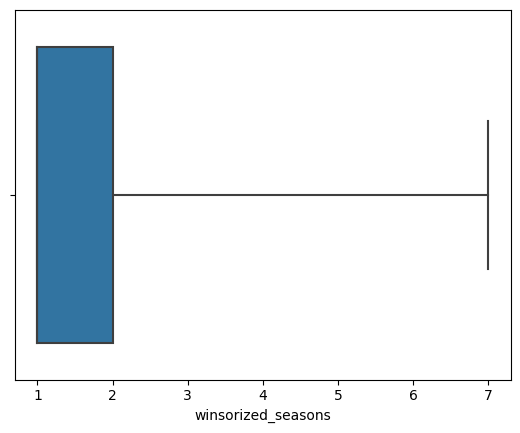

In [ ]:
raw_df['winsorized_seasons'] = stats.mstats.winsorize(raw_df['seasons'], (0, .03))
sns.boxplot(data=raw_df, x='winsorized_seasons', whis=5)
plt.show()

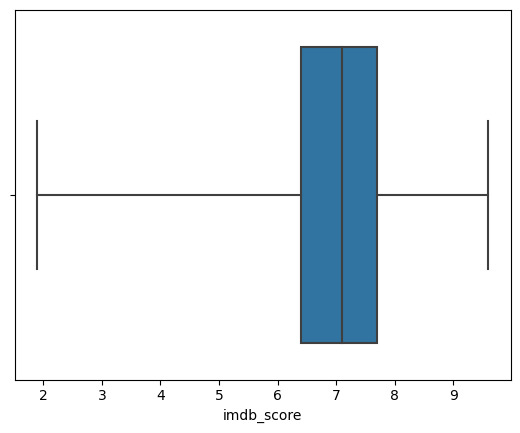

In [ ]:
sns.boxplot(data=raw_df, x='imdb_score', whis=5)
plt.show()

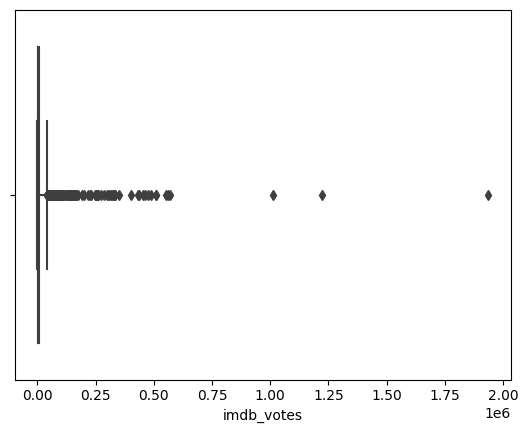

In [ ]:
sns.boxplot(data=raw_df, x='imdb_votes', whis=5)
plt.show()

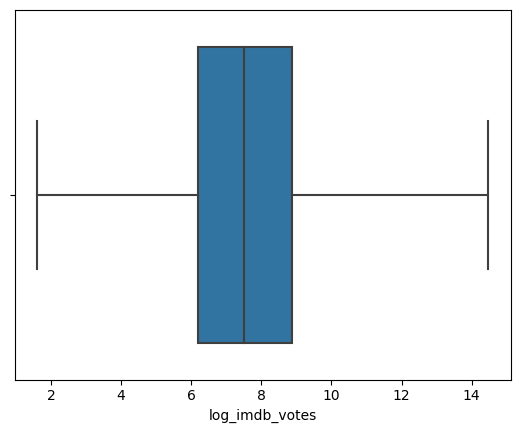

In [ ]:
raw_df['log_imdb_votes'] = np.log(raw_df['imdb_votes'])
sns.boxplot(data=raw_df, x='log_imdb_votes', whis=5)
plt.show()

Now that I've dealt with the outliers, it's time to move on to the data exploration stage.

# Data Exploration

Some of these variables exist for identification purposes only and won't actually be used in the model. The variables that need to be examined more closely are:


*   winsorized_release_year
*   age_certification
*   log_runtime
*   genres
*   production_countries
*   winsorized_seasons
*   log_imdb_votes
*   imdb_score










I'll create a new dataframe with the cleaned versions of the relevant variables and then examine each one of them.

In [ ]:
cleaned_df = raw_df[['winsorized_release_year', 'age_certification', 'log_runtime', 'genres',
             'production_countries', 'winsorized_seasons', 'log_imdb_votes', 'imdb_score']]

In [ ]:
cleaned_df.describe()

,winsorized_release_year,log_runtime,winsorized_seasons,log_imdb_votes,imdb_score
count,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000
mean,2018.192254,3.567478,1.955203,7.525938,6.992067
std,4.403907,0.515132,1.535101,2.123614,1.050784
min,1997.000000,0.693147,1.000000,1.609438,1.900000
25%,2017.000000,3.218876,1.000000,6.194403,6.400000
50%,2019.000000,3.737670,1.000000,7.514800,7.100000
75%,2021.000000,3.912023,2.000000,8.881347,7.700000
max,2023.000000,5.342334,7.000000,14.476373,9.600000


In [ ]:
cleaned_df.describe(include=['O'])

,age_certification,genres,production_countries
count,2143,2143,2143
unique,8,848,112
top,TV-MA,[reality],[US]
freq,972,139,806


The number of unique genres and production countries listed is actually the number of unique combinations of genres and production countries since each value is a list. Below I'll take the real number of unique genres and production countries.

In [ ]:
print(f'Number of unique genres: {len(genres_list)}')
print(f'Number of unique production countries: {len(countries_list)}')

Number of unique genres: 19
Number of unique production countries: 61


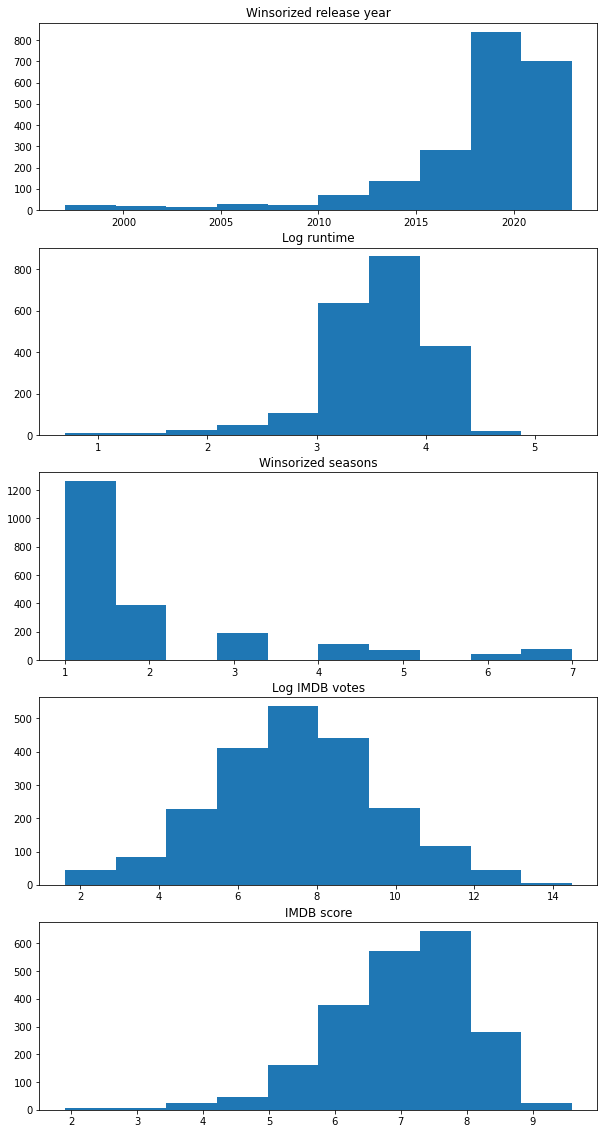

In [ ]:
plt.figure(figsize=(10,20))

plt.subplot(5, 1, 1)
plt.hist(cleaned_df['winsorized_release_year'])
plt.title('Winsorized release year')

plt.subplot(5, 1, 2)
plt.hist(cleaned_df['log_runtime'])
plt.title('Log runtime')

plt.subplot(5, 1, 3)
plt.hist(cleaned_df['winsorized_seasons'])
plt.title('Winsorized seasons')

plt.subplot(5, 1, 4)
plt.hist(cleaned_df['log_imdb_votes'])
plt.title('Log IMDB votes')

plt.subplot(5, 1, 5)
plt.hist(cleaned_df['imdb_score'])
plt.title('IMDB score')

plt.show()

log_imdb_votes is almost certainly normal.
imdb_score and log_runtime are fairly close to normal.
winsorized_seasons looks decidedly non-normal and winsorized_release_year looks left-skewed.

In [ ]:
cleaned_df.corr()

,winsorized_release_year,log_runtime,winsorized_seasons,log_imdb_votes,imdb_score
winsorized_release_year,1.000000,0.174859,-0.573829,-0.147181,-0.192856
log_runtime,0.174859,1.000000,-0.218794,0.234803,0.170264
winsorized_seasons,-0.573829,-0.218794,1.000000,0.287168,0.141162
log_imdb_votes,-0.147181,0.234803,0.287168,1.000000,0.322402
imdb_score,-0.192856,0.170264,0.141162,0.322402,1.000000


There aren't any truly strong correlations between variables. The strongest is between winsorized_release_year and winsorized_seasons with a moderate correlation of about -0.57. This makes sense, given that shows that have been released recently are often still ongoing and won't have released all their seasons yet. Now I'll take a look at the categorical data.

In [ ]:
cleaned_df.groupby('age_certification').mean()['imdb_score']

age_certification
TV-14       7.184749
TV-G        6.523171
TV-MA       6.993827
TV-PG       7.020833
TV-Y        6.681633
TV-Y7       6.865546
TV-Y7-FV    7.114286
missing     6.933178
Name: imdb_score, dtype: float64

In order to do something similar with genres and production_countries, I'll have to approach it a little differently, since the variables as they are currently stored are lists and therefore incompatible with the format I used for age_certification above.

In [ ]:
for genre in genres_list:
  count = 0
  score = 0
  for index, row in cleaned_df.iterrows():
    if genre in row['genres']:
      count+=1
      score+=row['imdb_score']
  print(f'Mean IMDB score for {genre}: {round(score/count, 2)}')

Mean IMDB score for comedy: 7.04
Mean IMDB score for european: 7.38
Mean IMDB score for animation: 6.97
Mean IMDB score for family: 6.76
Mean IMDB score for fantasy: 7.06
Mean IMDB score for music: 6.8
Mean IMDB score for drama: 7.17
Mean IMDB score for action: 7.02
Mean IMDB score for war: 7.54
Mean IMDB score for crime: 7.17
Mean IMDB score for scifi: 6.95
Mean IMDB score for reality: 6.4
Mean IMDB score for western: 7.28
Mean IMDB score for thriller: 7.07
Mean IMDB score for documentation: 7.12
Mean IMDB score for romance: 7.19
Mean IMDB score for horror: 6.87
Mean IMDB score for sport: 7.16
Mean IMDB score for history: 7.47


In [ ]:
for country in countries_list:
  count = 0
  score = 0
  for index, row in cleaned_df.iterrows():
    if country in row['production_countries']:
      count+=1
      score+=row['imdb_score']
  print(f'Mean IMDB score for {country}: {round(score/count, 2)}')

Mean IMDB score for GB: 7.13
Mean IMDB score for US: 6.9
Mean IMDB score for JP: 7.27
Mean IMDB score for CA: 6.89
Mean IMDB score for FR: 6.81
Mean IMDB score for AU: 7.07
Mean IMDB score for AR: 6.86
Mean IMDB score for DK: 7.19
Mean IMDB score for CO: 7.13
Mean IMDB score for IT: 6.89
Mean IMDB score for TW: 6.82
Mean IMDB score for KR: 7.54
Mean IMDB score for CN: 7.53
Mean IMDB score for ES: 6.59
Mean IMDB score for RU: 6.81
Mean IMDB score for IN: 6.86
Mean IMDB score for SG: 6.65
Mean IMDB score for NO: 7.17
Mean IMDB score for CL: 7.5
Mean IMDB score for SA: 6.8
Mean IMDB score for ZA: 5.94
Mean IMDB score for IS: 6.53
Mean IMDB score for IL: 7.51
Mean IMDB score for PL: 6.45
Mean IMDB score for TR: 7.01
Mean IMDB score for FI: 6.7
Mean IMDB score for NG: 6.42
Mean IMDB score for NL: 6.57
Mean IMDB score for IE: 7.3
Mean IMDB score for UA: 7.3
Mean IMDB score for BE: 6.92
Mean IMDB score for DE: 7.04
Mean IMDB score for BR: 6.63
Mean IMDB score for MX: 6.79
Mean IMDB score for 

# Feature engineering

Now that I've examined the variables and their relationships with each other, I'm ready to move on to the feature engineering stage. I did a little of this already in the data cleaning phase when I changed the datatype of the entries for genres and production_countries from str to list so I could better examine the data. Now I'll have to create dummy variables for those two variables and age_certification. For genres and production_countries, I'll do something a little different. Since there are entries with multiple genres and multiple production countries, I'll create dummy variables for each individual genre and each individual country rather than the list of genres or countries. So a given entry can have values of 1 for multiple dummy variables.

I'll start by creating a new name for the final version of the dataframe and add the dummy variables to that.

In [ ]:
df = cleaned_df.copy()

In [ ]:
df = pd.concat([df, pd.get_dummies(cleaned_df['age_certification'])], axis=1)

In [ ]:
for genre in genres_list:
  for index, row in df.iterrows():
    df.loc[index, genre] = int(genre in row['genres'])

In [ ]:
for country in countries_list:
  for index, row in df.iterrows():
    df.loc[index, country] = int(country in row['production_countries'])

In [ ]:
df.drop(['genres', 'production_countries', 'age_certification'], inplace=True, axis=1)

# Modeling

Now that I have a cleaned dataframe complete with dummy variables, I'm ready to move on to the modeling phase. I'll try a few basic models and compare their performances and then I'll focus on hyperparameter tuning. In the absence of any truly strong correlations between the features and target variable, I'm reluctant to lose variance by omitting features. I'll start by including all of them and if the model takes too long to train, I'll remove irrelevant features.

I'll try SVM, random forest, and boosting.

In [ ]:
X = df.drop('imdb_score', axis=1)
Y = df['imdb_score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

In [ ]:
basic_svm = SVR()
basic_svm.fit(X_train, Y_train)

print(f'R2 score on training data: {basic_svm.score(X_train, Y_train)}')
print(f'R2 score on test data: {basic_svm.score(X_test, Y_test)}')

R2 score on training data: -0.010354760042277533
R2 score on test data: -0.006802919592280521


In [ ]:
basic_rf = RandomForestRegressor()
basic_rf.fit(X_train, Y_train)

print(f'R2 score on training data: {basic_rf.score(X_train, Y_train)}')
print(f'R2 score on test data: {basic_rf.score(X_test, Y_test)}')

R2 score on training data: 0.900821604369402
R2 score on test data: 0.27810129376414716


In [ ]:
basic_gbr = GradientBoostingRegressor()
basic_gbr.fit(X_train, Y_train)

print(f'R2 score on training data: {basic_gbr.score(X_train, Y_train)}')
print(f'R2 score on test data: {basic_gbr.score(X_test, Y_test)}')

R2 score on training data: 0.514138720089582
R2 score on test data: 0.27613449627988573


# Random forest

The SVM performs terribly on both the testing and training data. The random forest and boosting regressors are much better, though neither generalizes well. With some tuning to address the overfitting, they might be reasonably reliable. The random forest had more promising initial results so I'll start by examining its hyperparameters.

In [ ]:
print('Current random forest hyperparameters in use:\n')
pprint(basic_rf.get_params())

Current random forest hyperparameters in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


I'll try random search cross-validation to narrow down the choices for my hyperparameters.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=30)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, verbose=2, n_jobs = -1, cv=3)

rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 216, 232, 248,
                                                         265, 281, 297, 314,
                                                         330, 346, 363, 379,
                                                         395, 412, 428, 444,
                                                         461, 477, 493, 510,
                                                         526, 542, 559, 575,
                                                         591, 608, 624, 640,
                                                         657, 673, ...]},
                   verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 58,
 'bootstrap': True}

Now I'll do grid search cross-validation to evaluate models with hyperparameters in the vicinity of the best parameters listed above.

In [ ]:
param_grid = {'n_estimators': [900, 1000, 1100],
              'min_samples_split':[4, 5, 6],
              'min_samples_leaf': [1, 2, 3],
              'max_features': ['sqrt'],
              'max_depth': [50, 60, 70],
              'bootstrap': [True]}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=2, cv=3)
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [50, 60, 70],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [900, 1000, 1100]},
             verbose=2)

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 900}

In [ ]:
rf = RandomForestRegressor(n_estimators=900, min_samples_split=4, min_samples_leaf=1,
                           max_features='sqrt', max_depth=70, bootstrap=True)

rf.fit(X_train, Y_train)
print(f'Score on training data: {rf.score(X_train, Y_train)}')
print(f'Score on test data: {rf.score(X_test, Y_test)}')

Score on training data: 0.7954852197376047
Score on test data: 0.3023579795008735


# Gradient boosting

The random forest's performance on the test data has improved but not by much and it's still badly overfitting. I'll try to improve the gradient boosting regressor instead.

First I'll get a sense for the best value for n_estimators to save time in the cross validation process later.

In [ ]:
for i in [30, 60, 100, 150, 200, 250, 300, 350]:
  gbr = GradientBoostingRegressor(n_estimators=i)
  gbr.fit(X_train,Y_train)

  print(f'n_estimators: {i}')
  print(f'R2 score on training data: {gbr.score(X_train, Y_train)}')
  print(f'R2 score on test data: {gbr.score(X_test, Y_test)}')
  print('-'*50)

n_estimators: 30
R2 score on training data: 0.35887088131930533
R2 score on test data: 0.26769486922153585
--------------------------------------------------
n_estimators: 60
R2 score on training data: 0.4465859912083199
R2 score on test data: 0.27582248366519013
--------------------------------------------------
n_estimators: 100
R2 score on training data: 0.514138720089582
R2 score on test data: 0.2797231926933623
--------------------------------------------------
n_estimators: 150
R2 score on training data: 0.5666056673076828
R2 score on test data: 0.27490655247637574
--------------------------------------------------
n_estimators: 200
R2 score on training data: 0.6011429257806071
R2 score on test data: 0.27542588395047896
--------------------------------------------------
n_estimators: 250
R2 score on training data: 0.6396105295739818
R2 score on test data: 0.2618029579743534
--------------------------------------------------
n_estimators: 300
R2 score on training data: 0.667443593

In [ ]:
for i in [80, 90, 100, 110, 120]:
  gbr = GradientBoostingRegressor(n_estimators=i)
  gbr.fit(X_train,Y_train)

  print(f'n_estimators: {i}')
  print(f'R2 score on training data: {gbr.score(X_train, Y_train)}')
  print(f'R2 score on test data: {gbr.score(X_test, Y_test)}')
  print('-'*50)

n_estimators: 80
R2 score on training data: 0.4893547006843044
R2 score on test data: 0.28286056207381494
--------------------------------------------------
n_estimators: 90
R2 score on training data: 0.5000071499873524
R2 score on test data: 0.27815342242100816
--------------------------------------------------
n_estimators: 100
R2 score on training data: 0.514138720089582
R2 score on test data: 0.28139190181483775
--------------------------------------------------
n_estimators: 110
R2 score on training data: 0.5254477622289508
R2 score on test data: 0.28055939798728413
--------------------------------------------------
n_estimators: 120
R2 score on training data: 0.5366176619341119
R2 score on test data: 0.27228592881950575
--------------------------------------------------


It looks like a value of about 80 is best for n_estimators. Now for the random search.

In [ ]:
n_estimators = [70, 80, 90]
max_features = ['auto', 'sqrt', .3, .6]
max_depth = [int(x) for x in np.linspace(start=5, stop=100, num=20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3]
warm_start = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'warm_start': warm_start}

In [ ]:
gbr = GradientBoostingRegressor()

gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid,
                               n_iter = 100, verbose=3, n_jobs = -1, cv=3)

gbr_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, None],
                                        'max_features': ['auto', 'sqrt', 0.3,
                                                         0.6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [70, 80, 90],
                                        'warm_start': [True, False]},
                   verbose=3)

In [ ]:
gbr_random.best_params_

{'warm_start': True,
 'n_estimators': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 5}

In [ ]:
param_grid = {'n_estimators': [80, 90, 100],
              'min_samples_split':[2, 3, 4],
              'min_samples_leaf': [1, 2, 3],
              'max_features': ['sqrt'],
              'max_depth': [3, 5, 7],
              'warm_start': [True]}

gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=-1, verbose=4, cv=3)
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [80, 90, 100], 'warm_start': [True]},
             verbose=4)

In [ ]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 80,
 'warm_start': True}

In [ ]:
gbr = GradientBoostingRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=2,
                                min_samples_split=2, n_estimators=80, warm_start=True)
gbr.fit(X_train, Y_train)

print(f'R2 score on training data: {gbr.score(X_train, Y_train)}')
print(f'R2 score on test data: {gbr.score(X_test, Y_test)}')

R2 score on training data: 0.6780555125991521
R2 score on test data: 0.302267954410406


Compared to the initial untuned gradient boosting model I made, this one performs better on both the training and test data. However, its performance is still far from perfect and it still doesn't generalize well.

# Conclusion

Using RandomizedSearchCV and GridSearchCV helped me to improve both the random forest model and the gradient boosting model but neither was particularly effective. Their scores on the test data were nearly identical so I would likely opt to use the random forest, given its superior performance on the training data. 

After having examined this dataset and reached a plateau in terms of test set R^2 score, I believe more data is required to build a truly effective model. If I were to continue to improve upon these models, I would gather more data in order to train on a larger dataset and reduce the influence of noise on the model. I would also want to gather data on more potential features in the hope that one or more of them would be a stronger indicator of the IMDB score.